In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, gamma, halfnorm, laplace, norm, truncnorm
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
import data_generator as dg

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# run just tv
# run all
# run just demand

# 0) MMM data generator

In [37]:
np.random.seed(10)

# Set parameters for data generator
start_date = "2021-01-01"
periods = 52 * 3
channels = ["tv", "social", "search"]
adstock_alphas = [0.50, 0.25, 0.05]
saturation_lamdas = [1.5, 2.5, 3.5]
betas = [350, 150, 50]
spend_scalars = [10, 15, 20]

df = dg.data_generator(start_date, periods, channels, spend_scalars, adstock_alphas, saturation_lamdas, betas)

# Scale betas using maximum sales value - this is so it is comparable to the fitted beta from pymc (pymc does feature and target scaling using MaxAbsScaler from sklearn)
betas_scaled = [
    ((df["tv_sales"] / df["sales"].max()) / df["tv_saturated"]).mean(),
    ((df["social_sales"] / df["sales"].max()) / df["social_saturated"]).mean(),
    ((df["search_sales"] / df["sales"].max()) / df["search_saturated"]).mean()
]

# Calculate contributions
contributions = np.asarray([
    round((df["tv_sales"].sum() / df["sales"].sum()), 2),
    round((df["social_sales"].sum() / df["sales"].sum()), 2),
    round((df["search_sales"].sum() / df["sales"].sum()), 2),
    round((df["demand"].sum() / df["sales"].sum()), 2)
])

df[["date", "demand", "demand_proxy", "tv_spend_raw", "social_spend_raw", "search_spend_raw", "sales"]]

,date,demand,demand_proxy,tv_spend_raw,social_spend_raw,search_spend_raw,sales
0,2021-01-03,356.003195,330.831226,5501.441206,5894.908137,7182.864568,489.566208
1,2021-01-10,301.006385,317.461345,2507.942445,5791.555554,6312.367780,441.138691
2,2021-01-17,81.538923,89.223970,1049.661462,1081.642708,1429.740857,152.309451
3,2021-01-24,241.765941,169.729439,3008.937195,5323.913163,6185.584938,367.160745
4,2021-01-31,311.145259,349.047382,3171.490614,6830.642777,7227.783598,465.083840
...,...,...,...,...,...,...,...
151,2023-11-26,504.966471,517.052302,4065.830904,10716.104909,9975.069784,743.618076
152,2023-12-03,604.005118,633.299525,3740.575561,7287.215373,16792.317339,822.314394
153,2023-12-10,525.265482,438.144702,6442.185846,11242.173092,6893.282177,763.558935
154,2023-12-17,458.850104,581.817816,4555.589865,3870.492537,6558.943829,646.468794


# 1) Experiment generator

In [39]:
def exp_generator(start_date, periods, channel, adstock_alpha, saturation_lamda, beta, weekly_spend, max_abs_spend, freq="W"):
    
    # 0. Create time dimension
    date_range = pd.date_range(start=start_date, periods=periods, freq=freq)
    df_exp = pd.DataFrame({'date': date_range})

    # 1. Create raw channel spend
    df_exp[f"{channel}_spend_raw"] = weekly_spend

    # 2. Scale channel spend
    df_exp[f"{channel}_spend"] = df_exp[f"{channel}_spend_raw"] / max_abs_spend

    # 3. Apply adstock transformation
    df_exp[f"{channel}_adstock"] = geometric_adstock(
        x=df_exp[f"{channel}_spend"].to_numpy(),
        alpha=adstock_alpha,
        l_max=8, normalize=True
    ).eval().flatten()

    # 4. Apply saturation transformation
    df_exp[f"{channel}_saturated"] = logistic_saturation(
        x=df_exp[f"{channel}_adstock"].to_numpy(),
        lam=saturation_lamda
    ).eval()

    # 5. Calculate contribution to sales
    df_exp[f"{channel}_sales"] = df_exp[f"{channel}_saturated"] * beta
    
    return df_exp

In [54]:
# Set parameters for experiment generator
start_date = "2024-10-01"
periods = 8
channel = "tv"
adstock_alpha = adstock_alphas[0]
saturation_lamda = saturation_lamdas[0]
beta = betas[0]
weekly_spend = df["tv_spend_raw"].mean()
max_abs_spend = df["tv_spend_raw"].max()

df_exp_tv = exp_generator(start_date, periods, channel, adstock_alpha, saturation_lamda, beta, weekly_spend, max_abs_spend)

df_exp_tv

,date,tv_spend_raw,tv_spend,tv_adstock,tv_saturated,tv_sales
0,2024-10-06,3988.314882,0.31291,0.157069,0.117260,41.040836
1,2024-10-13,3988.314882,0.31291,0.235603,0.174886,61.210012
2,2024-10-20,3988.314882,0.31291,0.274870,0.203281,71.148320
3,2024-10-27,3988.314882,0.31291,0.294504,0.217354,76.074061
4,2024-11-03,3988.314882,0.31291,0.304320,0.224358,78.525260
5,2024-11-10,3988.314882,0.31291,0.309229,0.227851,79.747841
6,2024-11-17,3988.314882,0.31291,0.311683,0.229595,80.358366
7,2024-11-24,3988.314882,0.31291,0.312910,0.230467,80.663435


In [55]:
weekly_sales = df_exp_tv["tv_sales"].mean()

weekly_sales

71.09601635209634

# 2) Lift test results

In [64]:
df_lift_test = pd.DataFrame({
    "channel": ["tv_spend_raw"],
    "x": [0],
    "delta_x": weekly_spend,
    "delta_y": weekly_sales,
    "sigma": [weekly_sales * 0.05],
    }
)

df_lift_test

,channel,x,delta_x,delta_y,sigma
0,tv_spend_raw,0,3988.314882,71.096016,3.554801


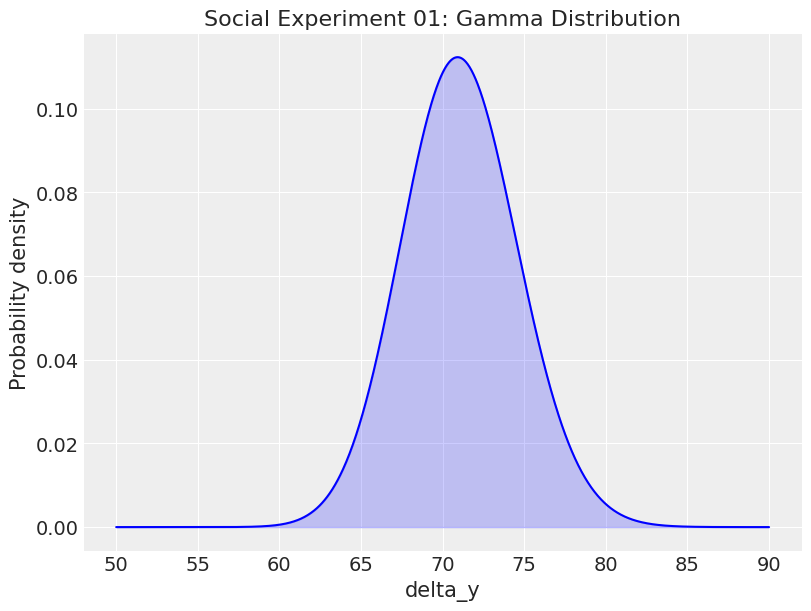

In [65]:
mu = df_lift_test["delta_y"]
sigma = df_lift_test["sigma"]

beta = mu / sigma**2
alpha = mu * beta

x2 = np.linspace(50, 90, 1000)
y2 = gamma.pdf(x2, a=alpha, scale=1/beta)

plt.figure(figsize=(8, 6))
plt.plot(x2, y2, 'b-')
plt.fill_between(x2, y2, alpha=0.2, color='blue')
plt.title('TV Experiment 01: Gamma Distribution')
plt.xlabel('delta_y')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

# 3) Calibrate model

In [66]:
# set date column
date_col = "date"

# set outcome column
y_col = "sales"

# set marketing variables
channel_cols = ["tv_spend_raw",
                "social_spend_raw",
                "search_spend_raw"]

# set control variables
control_cols = ["demand_proxy"]

# create arrays
X = df[[date_col] + channel_cols + control_cols]
y = df[y_col]

# set test (out-of-sample) length
test_len = 8

# create train and test indexs
train_idx = slice(0, len(df) - test_len)
out_of_time_idx = slice(len(df) - test_len, len(df))

In [74]:
mmm_default = MMM.load("./mmm_default.nc")
mmm_default.add_lift_test_measurements(df_lift_test)
mmm_default.fit(X[train_idx], y[train_idx])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 226 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

# 4) Validate model

In [75]:
mmm_default.idata["sample_stats"]["diverging"].sum().item()

1

In [76]:
az.summary(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.002,0.025,-0.044,0.047,0.001,0.001,1862.0,1499.0,1.0
y_sigma,0.030,0.002,0.027,0.034,0.000,0.000,3138.0,2526.0,1.0
saturation_beta[tv_spend_raw],0.646,0.459,0.167,1.487,0.012,0.008,1844.0,1856.0,1.0
saturation_beta[social_spend_raw],0.213,0.033,0.155,0.267,0.001,0.001,2071.0,1581.0,1.0
saturation_beta[search_spend_raw],0.203,0.199,0.051,0.449,0.006,0.004,1674.0,1196.0,1.0
saturation_lam[tv_spend_raw],0.984,0.528,0.157,1.924,0.011,0.008,1878.0,1820.0,1.0
saturation_lam[social_spend_raw],4.072,1.050,2.122,6.106,0.025,0.018,1814.0,1279.0,1.0
saturation_lam[search_spend_raw],2.204,1.231,0.177,4.304,0.029,0.021,1572.0,1241.0,1.0
adstock_alpha[tv_spend_raw],0.249,0.084,0.088,0.404,0.002,0.001,2677.0,1342.0,1.0
adstock_alpha[social_spend_raw],0.193,0.074,0.054,0.334,0.001,0.001,2542.0,1519.0,1.0


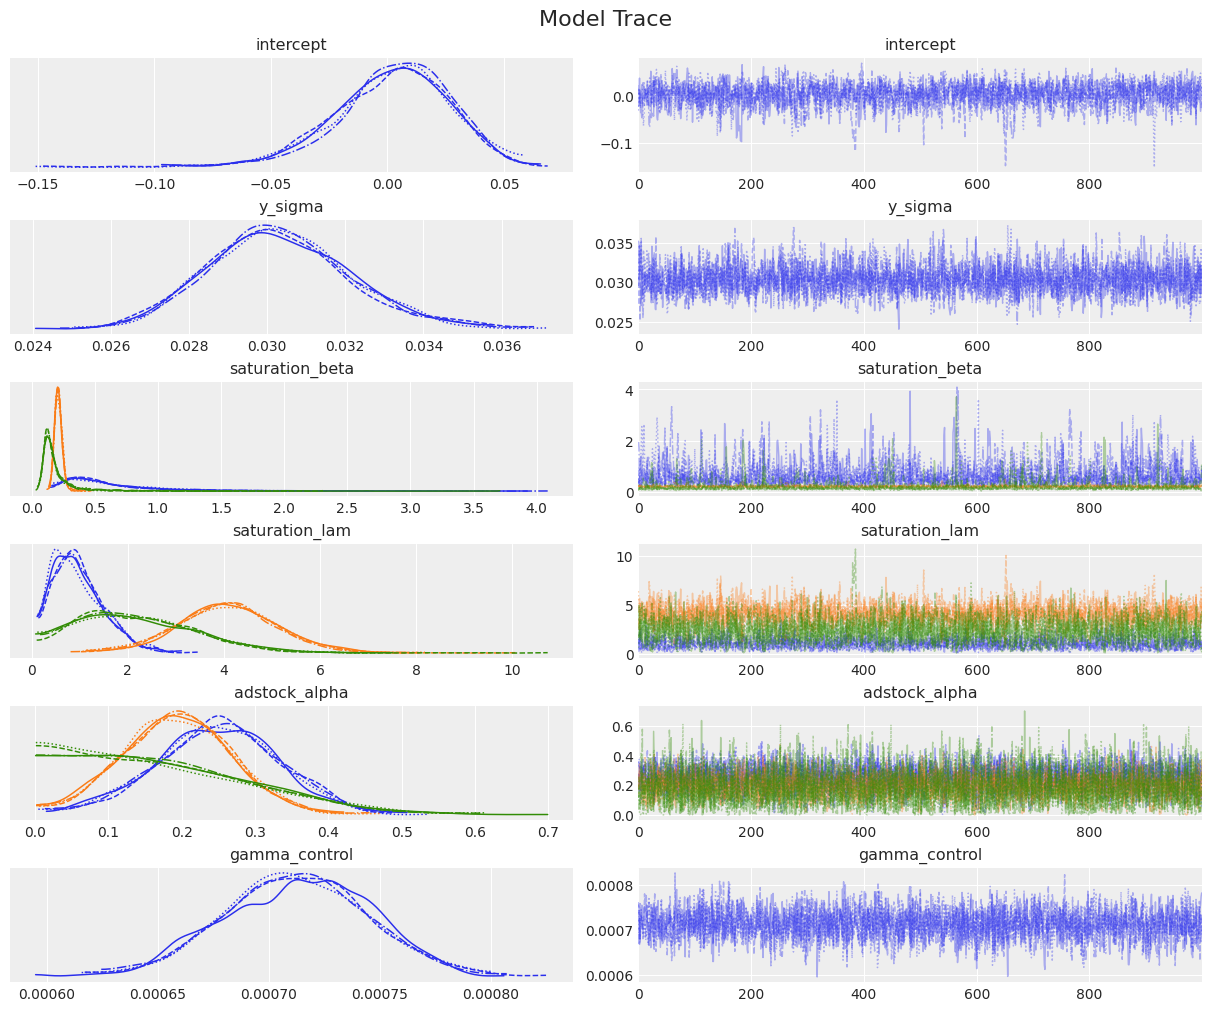

In [77]:
_ = az.plot_trace(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [78]:
mmm_default.sample_posterior_predictive(X[train_idx], extend_idata=True, combined=True)

Sampling: [lift_measurements, y]


Output()

<xarray.Dataset> Size: 5MB
Dimensions:                  (lift_measurements_dim_2: 1, sample: 4000,
                              date: 148)
Coordinates:
  * lift_measurements_dim_2  (lift_measurements_dim_2) int32 4B 0
  * date                     (date) datetime64[ns] 1kB 2021-01-03 ... 2023-10-29
  * sample                   (sample) object 32kB MultiIndex
  * chain                    (sample) int32 16kB 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3
  * draw                     (sample) int32 16kB 0 1 2 3 4 ... 996 997 998 999
Data variables:
    lift_measurements        (lift_measurements_dim_2, sample) float64 32kB 0...
    y                        (sample, date) float64 5MB 424.2 438.5 ... 506.8
Attributes:
    created_at:                 2024-10-01T12:55:55.589851+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

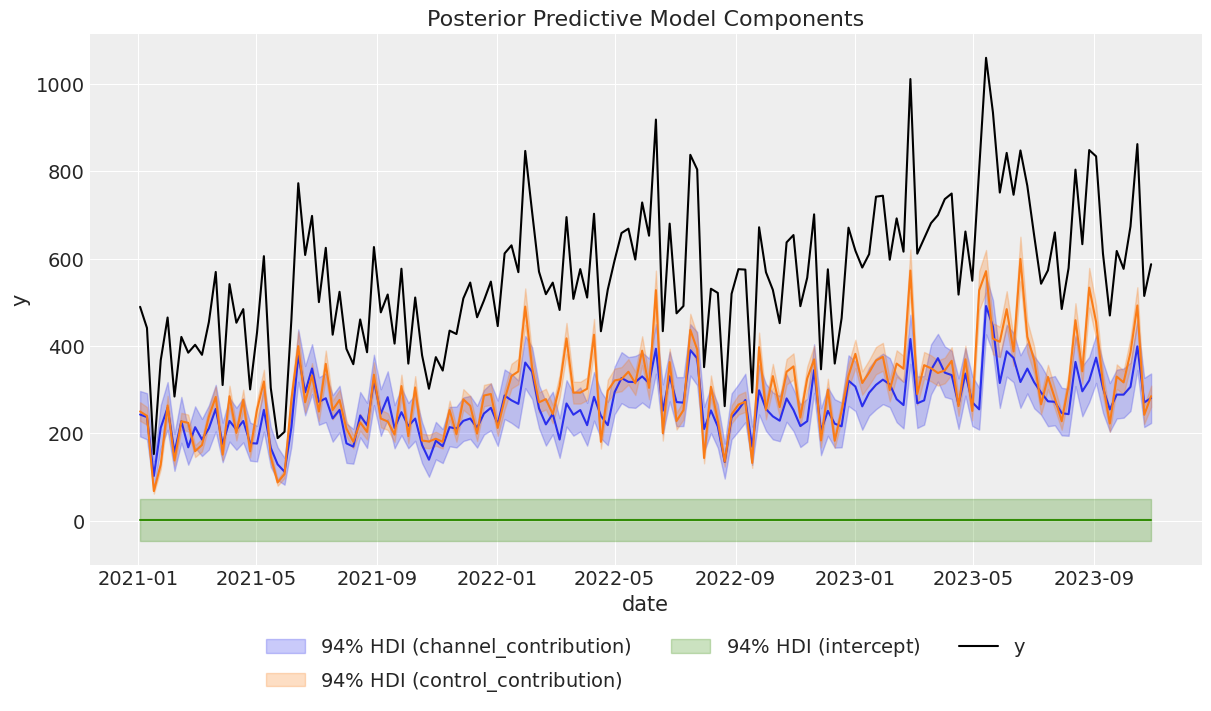

In [79]:
mmm_default.plot_components_contributions(original_scale=True);

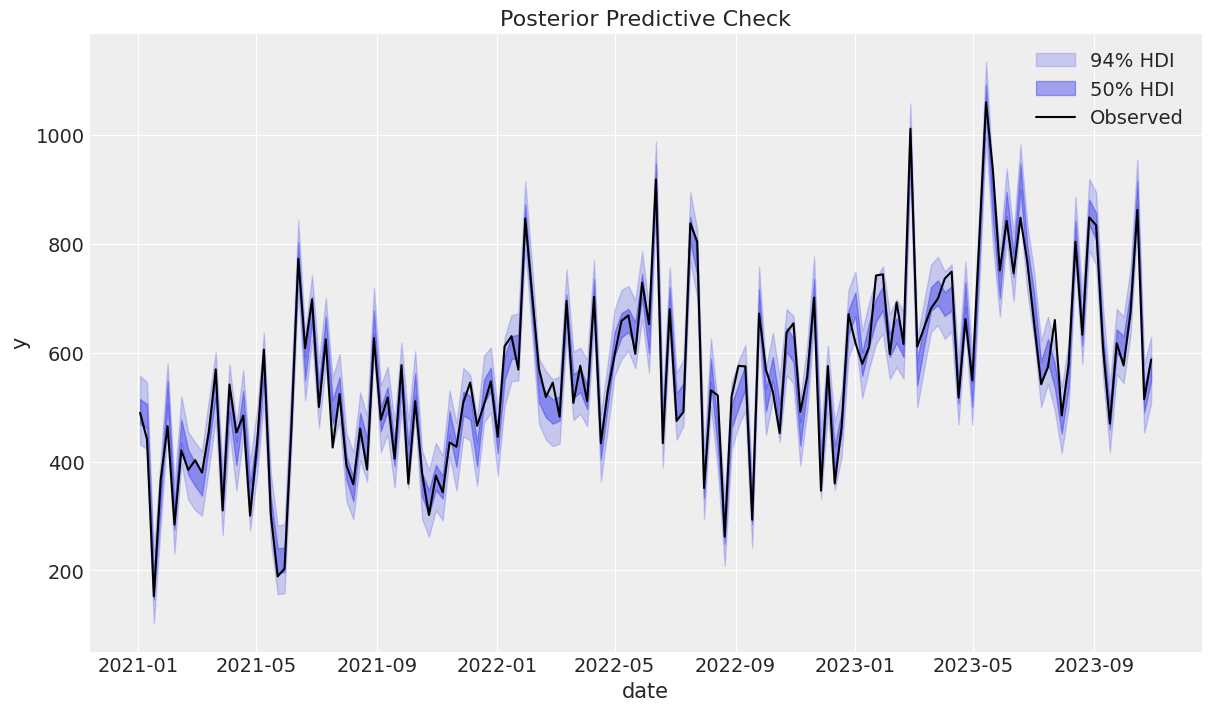

In [80]:
mmm_default.plot_posterior_predictive(original_scale=True);

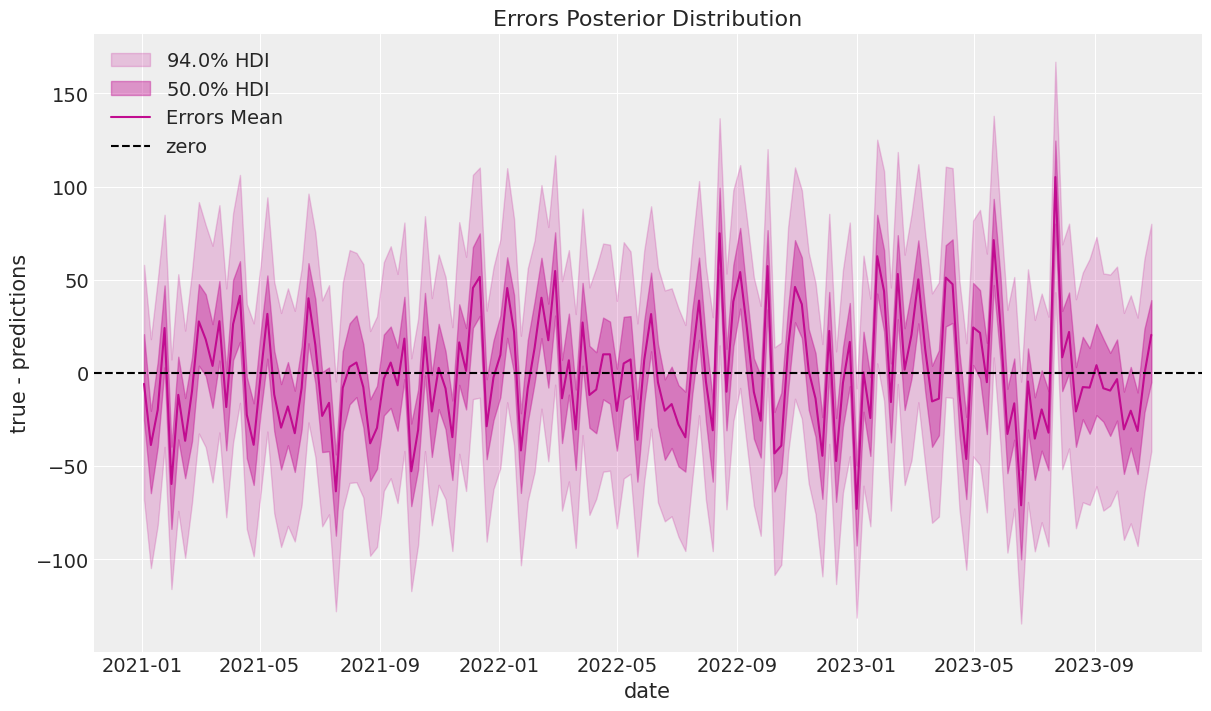

In [81]:
mmm_default.plot_errors(original_scale=True);

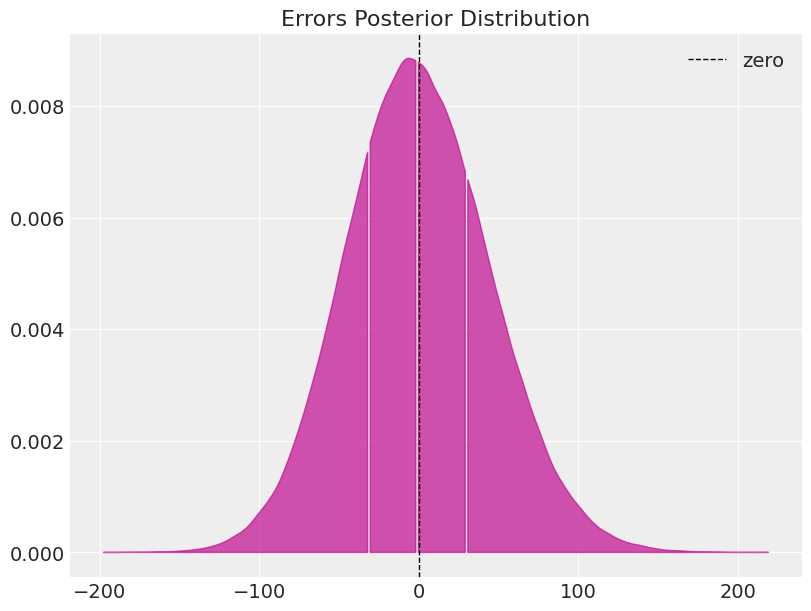

In [82]:
errors = mmm_default.get_errors(original_scale=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

Sampling: [lift_measurements, y]


Output()

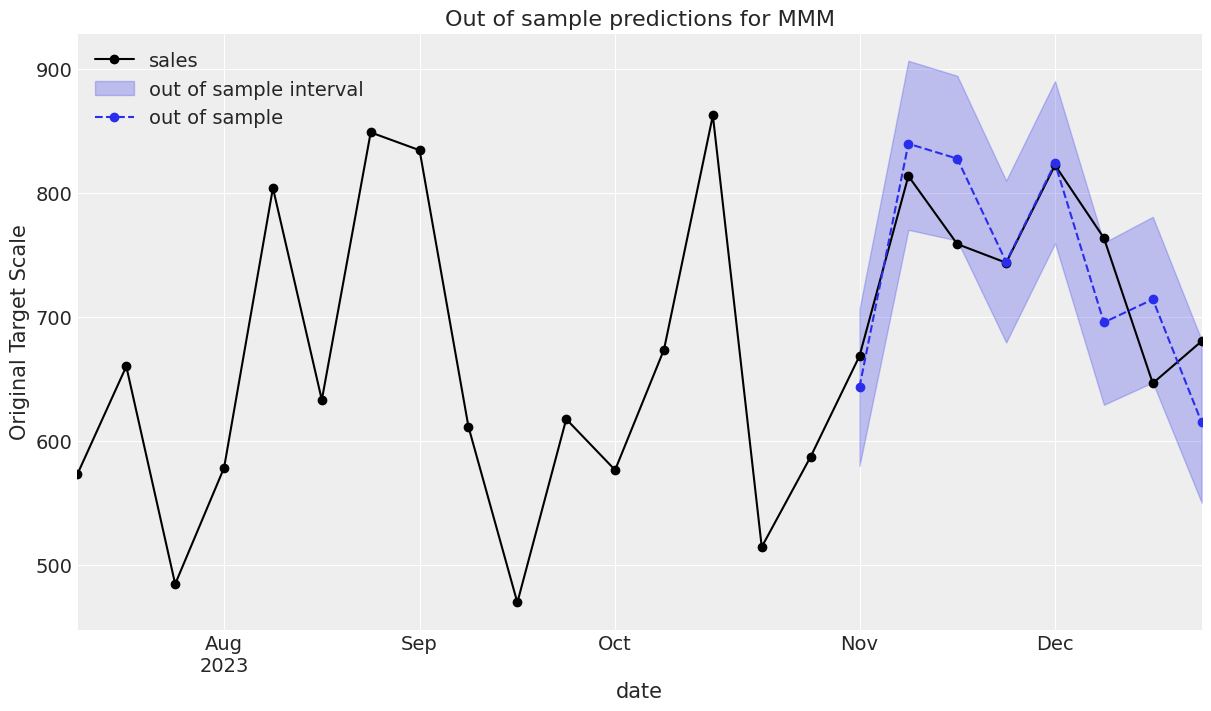

In [83]:
y_out_of_sample = mmm_default.sample_posterior_predictive(
    X_pred=X[out_of_time_idx], extend_idata=False, include_last_observations=True
)

def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X[date_col])
        .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax


def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample[date_col].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax


_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax, n_points=len(X[out_of_time_idx])*3)
plot_out_of_sample(
    X[out_of_time_idx], y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
ax.legend(loc="upper left");

# 5) Parameter validation - Channel betas

In [84]:
channels = np.array(["tv", "social", "search", "demand"])

true_contributions = pd.DataFrame({'Channels': channels, 'Contributions': contributions})
true_contributions= true_contributions.sort_values(by='Contributions', ascending=False).reset_index(drop=True)
true_contributions = true_contributions.style.bar(subset=['Contributions'], color='lightblue')

true_contributions

,Channels,Contributions
0,demand,0.700000
1,tv,0.140000
2,social,0.110000
3,search,0.050000


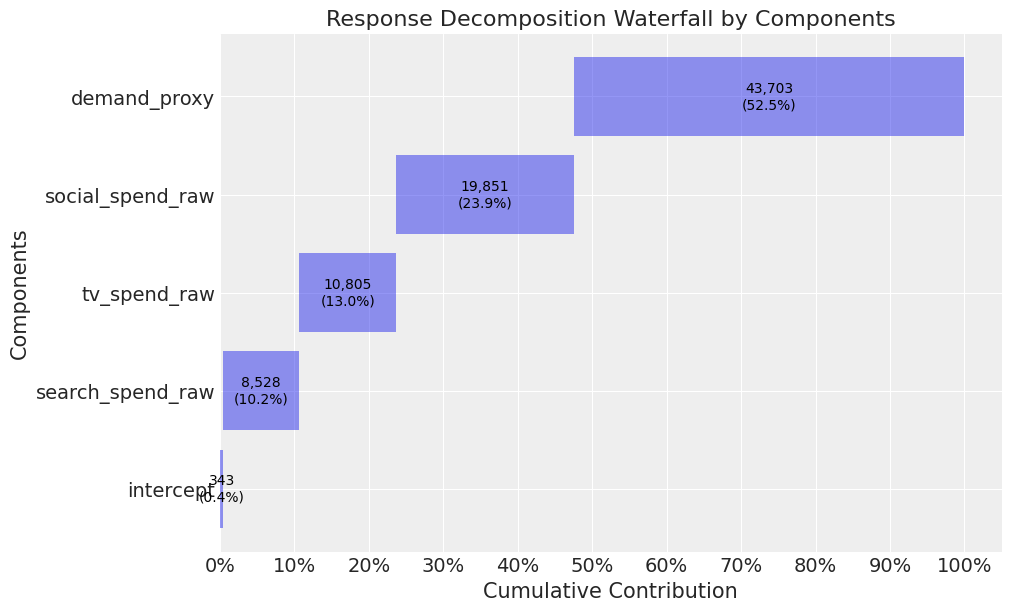

In [85]:
mmm_default.plot_waterfall_components_decomposition(figsize=(10,6));